In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.ticker as ticker
import sklearn, xgboost as xgb 

# Used to color bar charts for each team
color_df = pd.read_csv("Data/team_colors.csv")

print("sklearn:", sklearn.__version__)
print("xgboost:", xgb.__version__)

sklearn: 1.7.2
xgboost: 3.1.3


In [3]:
# Read in data and add log salary
df_original = pd.read_csv("Data/clean/master_data.csv")
df_original["log salary"] = np.log(df_original["Salary"])

# Include each team hex color for graphing 
df_merged = df_original.merge(color_df, on="Team", how="left")

# EDA 2025 
df_2025 = df_merged[df_merged["Year"] == 2025].sort_values("Salary")
df_2025 

,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,hex
2057,Drew Timme,timmedr01,BRK,254,-3.9,-2.8,-0.3,PF,2025,113055.0,11.635630,#000000
1102,Isaac Jones,jonesis01,SAC,304,-0.9,-0.8,0.0,PF,2025,152957.0,11.937912,#5B2B82
736,Jordan Goodwin,goodwjo01,LAL,543,-1.7,0.8,0.2,PG,2025,223718.0,12.318142,#552582
2083,P.J. Tucker,tuckepj01,NYK,58,-4.8,-2.4,-0.1,SF,2025,246833.0,12.416467,#F58426
1162,Kevin Knox,knoxke01,GSW,84,-0.7,-0.6,0.0,SF,2025,263939.0,12.483473,#1D428A
...,...,...,...,...,...,...,...,...,...,...,...,...
168,Bradley Beal,bealbr01,PHO,1702,-0.1,-1.0,0.4,SG,2025,50203930.0,17.731604,#E55F20
591,Kevin Durant,duranke01,PHO,2265,3.9,-0.7,3.0,PF,2025,51179021.0,17.750840,#E55F20
620,Joel Embiid,embiijo01,PHI,574,3.7,-0.3,0.8,C,2025,51415938.0,17.755459,#006BB6
1084,Nikola Jokić,jokicni01,DEN,2571,9.9,3.3,9.8,C,2025,51415938.0,17.755459,#0D2240


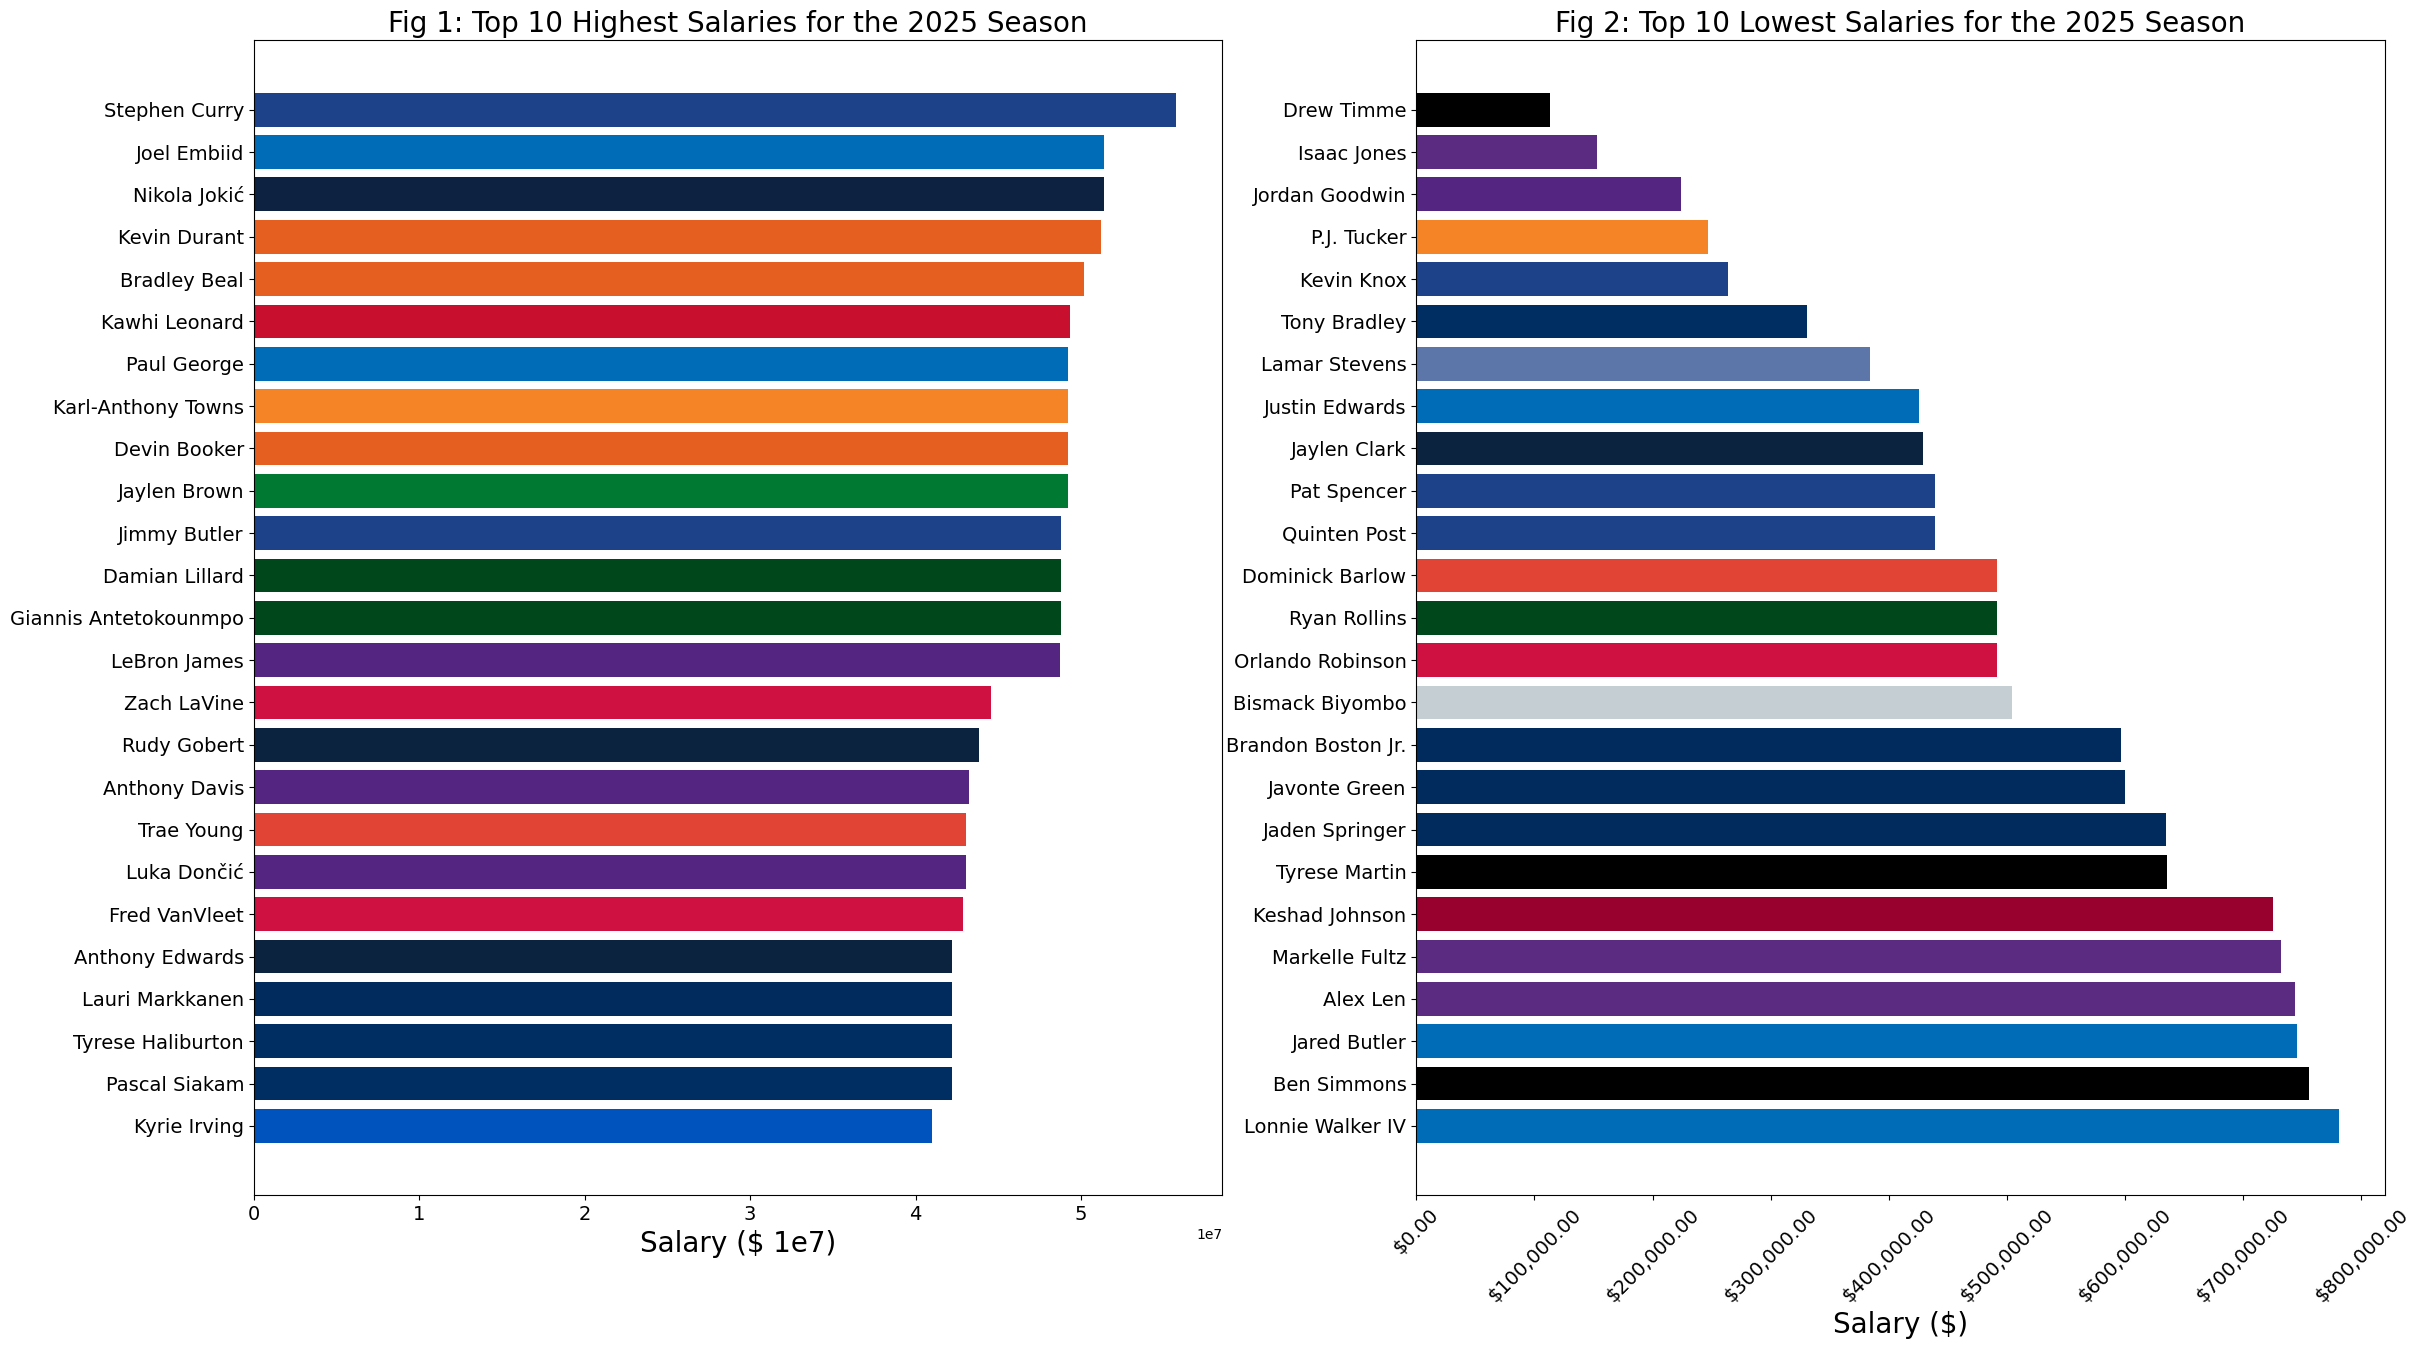

In [54]:

highest_paid_10 = df_2025.sort_values("Salary", ascending=False).head(25).sort_values("Salary", ascending=True)
lowest_paid_10 = df_2025.sort_values("Salary", ascending=True).head(25).sort_values("Salary", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(27.5, 15), sharey=False)

ax[0].barh(highest_paid_10["Player"], highest_paid_10["Salary"], color=highest_paid_10["hex"])
ax[0].set_title("Fig 1: Top 10 Highest Salaries for the 2025 Season", size=20, y=1)
ax[0].tick_params(axis="both", labelsize=14)
ax[0].set
ax[0].set_xlabel("Salary ($ 1e7)", size=20)

ax[1].barh(y=lowest_paid_10["Player"], width = lowest_paid_10["Salary"], color=lowest_paid_10["hex"])
ax[1].set_title("Fig 2: Top 10 Lowest Salaries for the 2025 Season", size=20, y = 1)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].set
ax[1].set_xlabel("Salary ($)", size=20)
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))



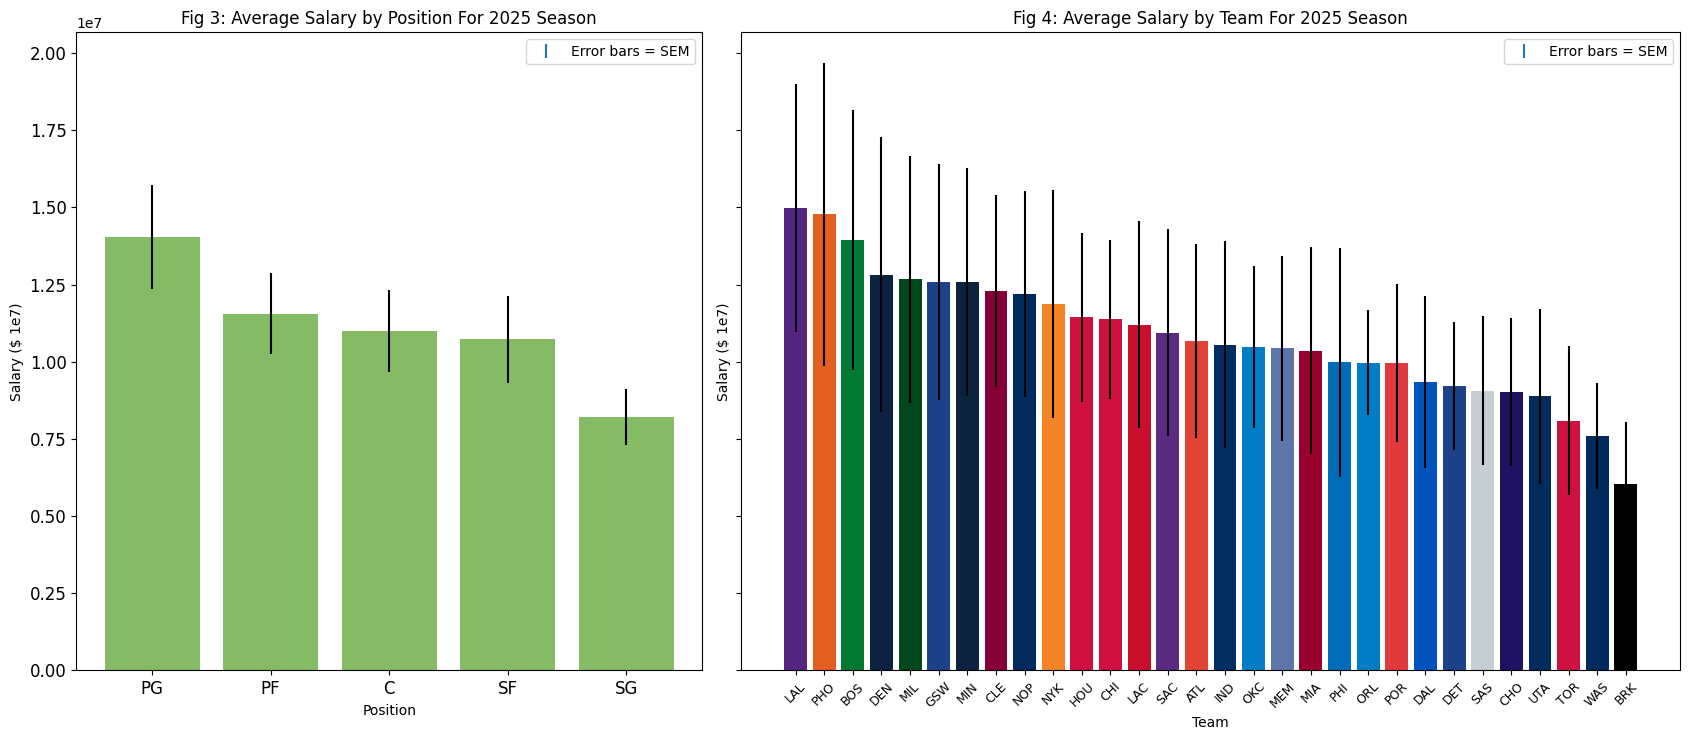

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Means (sorted)
pos_mean  = df_2025.groupby("Pos")["Salary"].mean().sort_values(ascending=False)
team_mean = df_2025.groupby("Team")["Salary"].mean().sort_values(ascending=False)

# SEM (same order as means)
pos_sem  = df_2025.groupby("Pos")["Salary"].sem().reindex(pos_mean.index)
team_sem = df_2025.groupby("Team")["Salary"].sem().reindex(team_mean.index)

# Build team plot df + merge colors (must happen before plotting)
team_plot = team_mean.reset_index().rename(columns={"Salary": "Salary_mean"})
team_plot["Salary_sem"] = team_sem.values
team_plot = team_plot.merge(color_df, on="Team", how="left")

# Plot
fig, ax = plt.subplots(
    1, 2, figsize=(17, 7.5),
    sharey=True,
    gridspec_kw={"width_ratios": [2, 3]}
)

ax[0].bar(pos_mean.index, pos_mean.values, yerr=pos_sem, color="#85BB65")
ax[0].set_xlabel("Position")
ax[0].set_ylabel("Salary ($ 1e7)")
ax[0].set_title("Fig 3: Average Salary by Position For 2025 Season")
ax[0].tick_params(axis="x", labelsize=12)
ax[0].tick_params(axis="y", labelsize=12)
ax[0].errorbar([], [], yerr=[1], fmt="none", capsize=10, label="Error bars = SEM")


ax[1].bar(team_plot["Team"], team_plot["Salary_mean"], yerr=team_sem, color=team_plot["hex"])
ax[1].set_xlabel("Team")
ax[1].set_ylabel("Salary ($ 1e7)")
ax[1].set_title("Fig 4: Average Salary by Team For 2025 Season")
ax[1].tick_params(axis="x", labelrotation=90, labelsize=9)
ax[1].tick_params(axis="y", labelsize=12)
ax[1].errorbar([], [], yerr=[1], fmt="none", capsize=10, label="Error bars = SEM")
ax[1].tick_params(axis='x', labelrotation=45)

# Legend for positions
legend_handle = Patch(
    facecolor="#000000",
    label="Average Salary ± SEM"
)

ax[0].legend()

ax[1].legend()

plt.tight_layout()
plt.show()


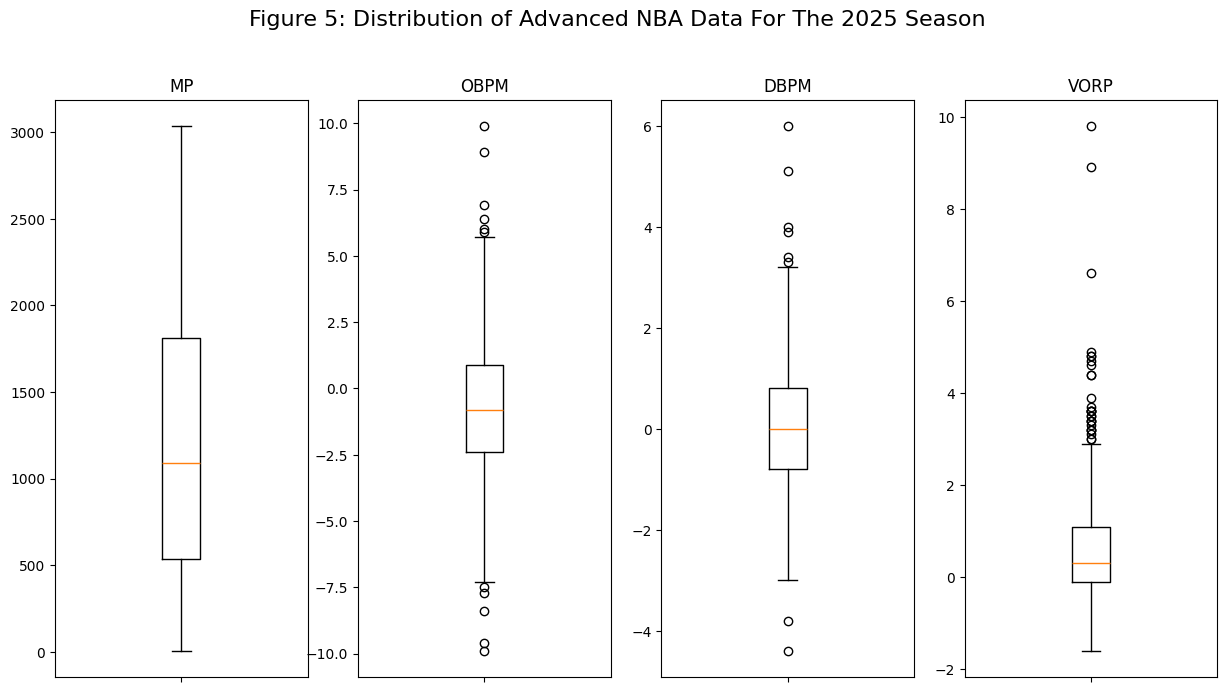

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP"]

for j, col in enumerate(cols):
    ax[j].boxplot(df_2025[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)


fig.suptitle("Figure 5: Distribution of Advanced NBA Data For The 2025 Season", fontsize=16, y=1)
plt.show()


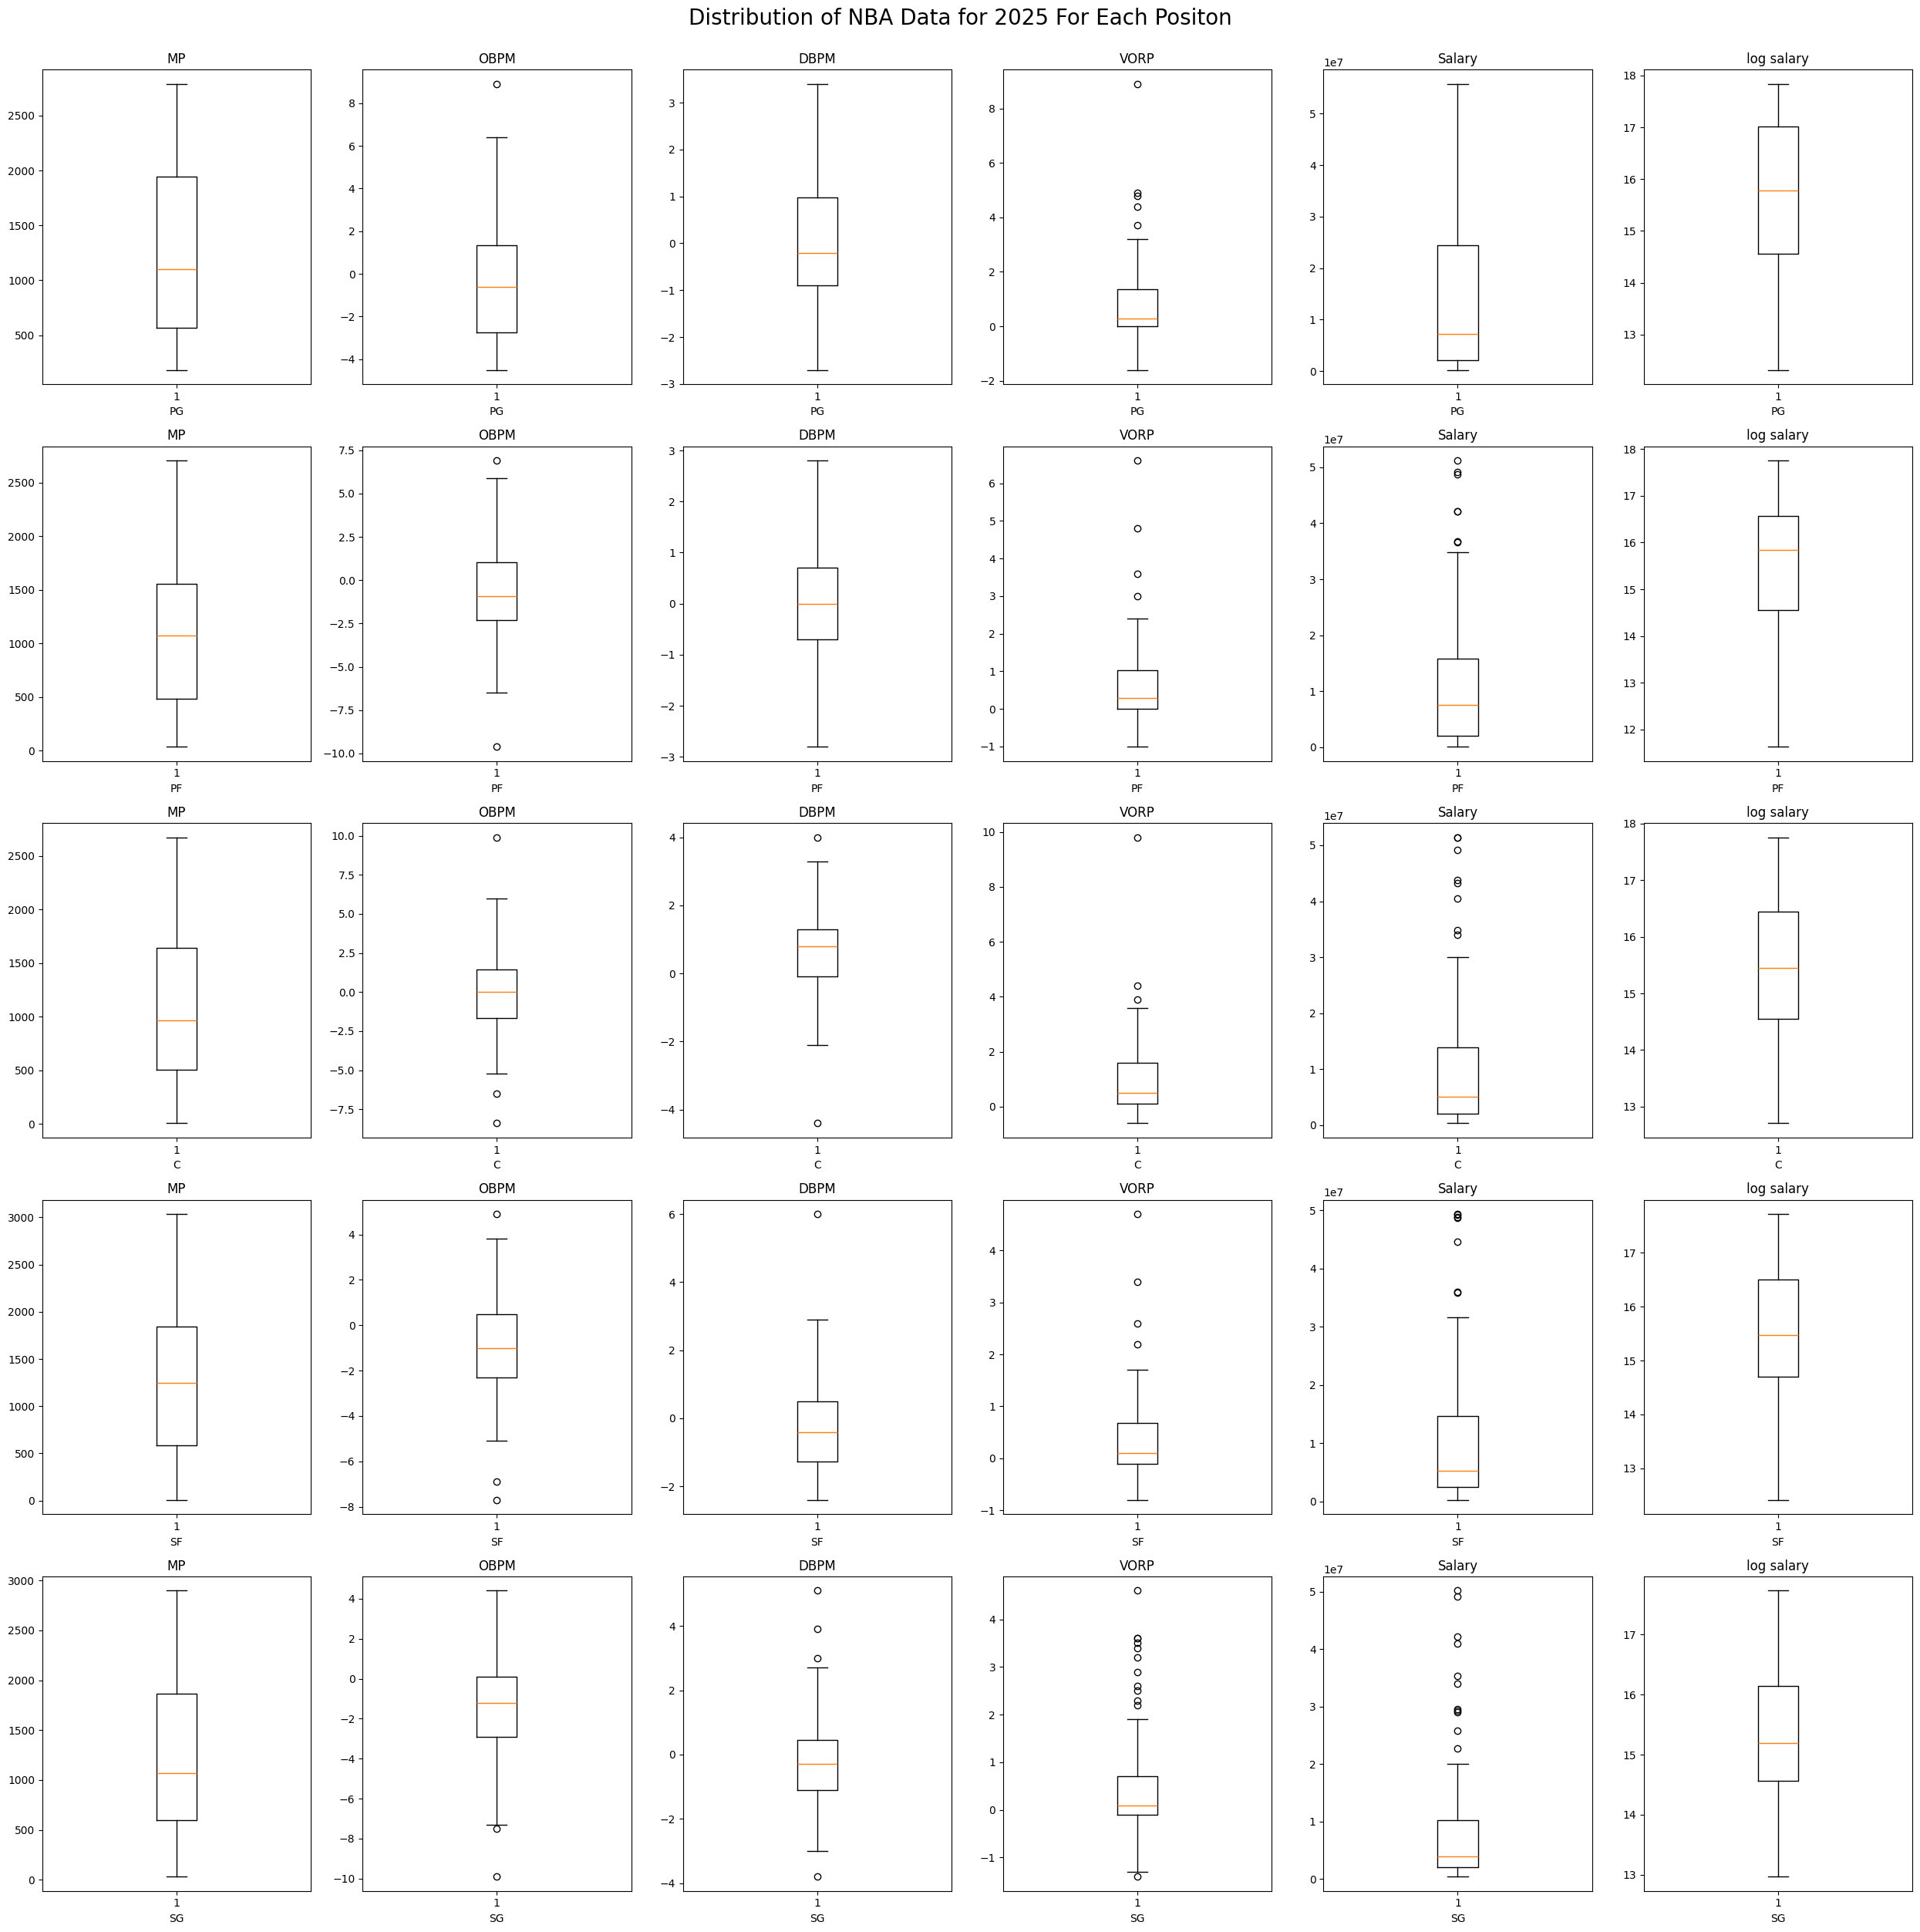

In [7]:
fig, ax = plt.subplots(5, 6, figsize=(25, 25), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary","log salary"]
pos = ["PG", "PF", "C", "SF", "SG"]  

for i, p in enumerate(pos):                 # rows
    dfp = df_2025[df_2025["Pos"] == p]      
    for j, col in enumerate(cols):          # cols
        ax[i, j].boxplot(dfp[col].dropna(), vert=True)
        ax[i, j].set_title(col)
        ax[i, j].set_xlabel(p)

fig.suptitle("Distribution of NBA Data for 2025 For Each Positon", fontsize=20, y=1 )
plt.tight_layout()
plt.show()

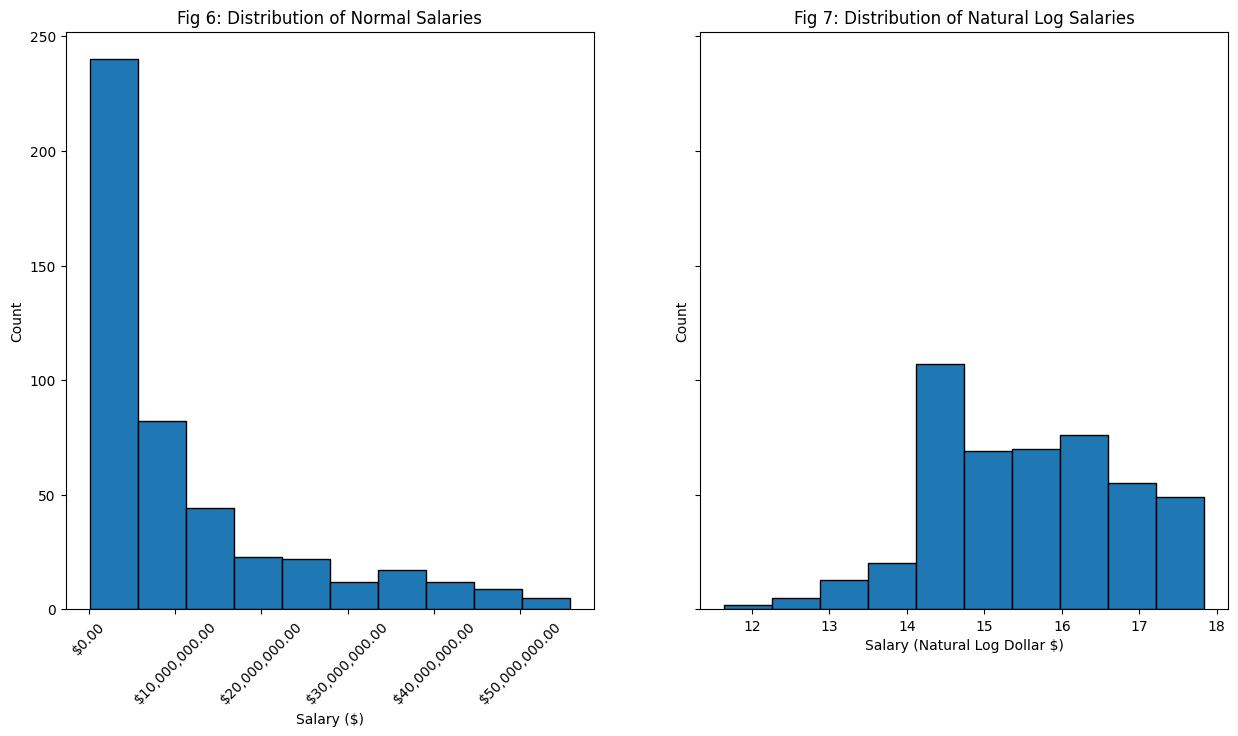

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5), sharey=True)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary","log salary"]

formatter = ticker.FormatStrFormatter('%d')


ax[0].hist(df_2025["Salary"], edgecolor='black')
ax[0].set_title("Fig 6: Distribution of Normal Salaries")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Salary ($)")
ax[0].xaxis.set_major_formatter(formatter)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))

ax[1].hist(df_2025["log salary"], edgecolor='black')
ax[1].set_title("Fig 7: Distribution of Natural Log Salaries")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Salary (Natural Log Dollar $)")


plt.show()

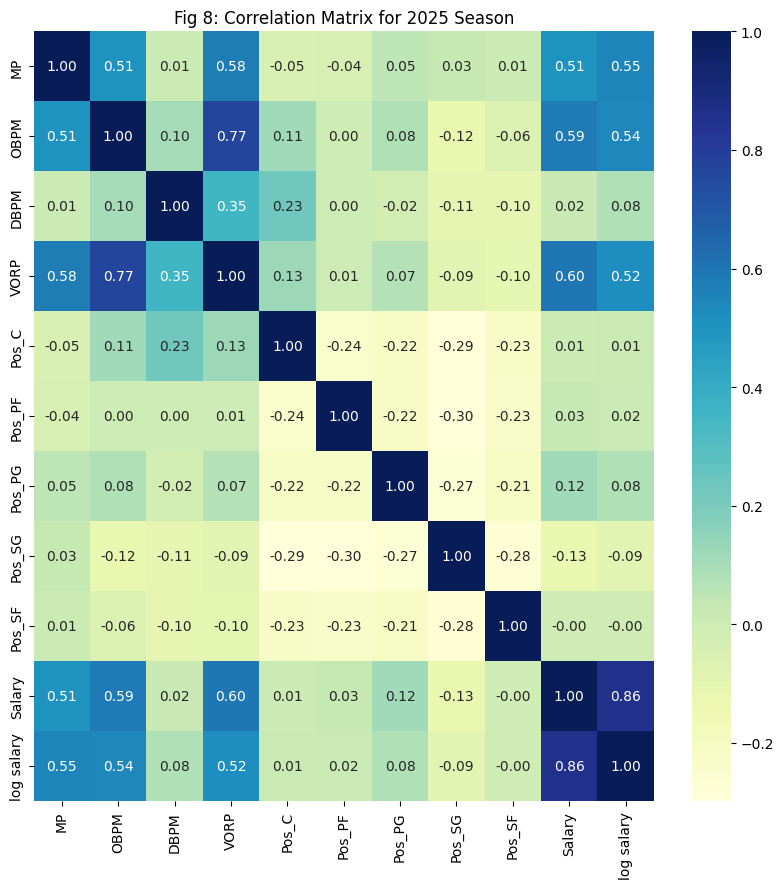

In [9]:
pos_encoded = pd.get_dummies(df_2025['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_2025, pos_encoded], axis=1)


df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "Salary", "log salary"]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Fig 8: Correlation Matrix for 2025 Season") 
plt.tick_params(axis="x", labelrotation=90)

plt.show() 

In [10]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
Salary        0.858785
MP            0.552239
OBPM          0.542379
VORP          0.518577
DBPM          0.077350
Pos_PG        0.076834
Pos_PF        0.019713
Pos_C         0.013404
Pos_SF       -0.002306
Pos_SG       -0.092651
Name: log salary, dtype: float64

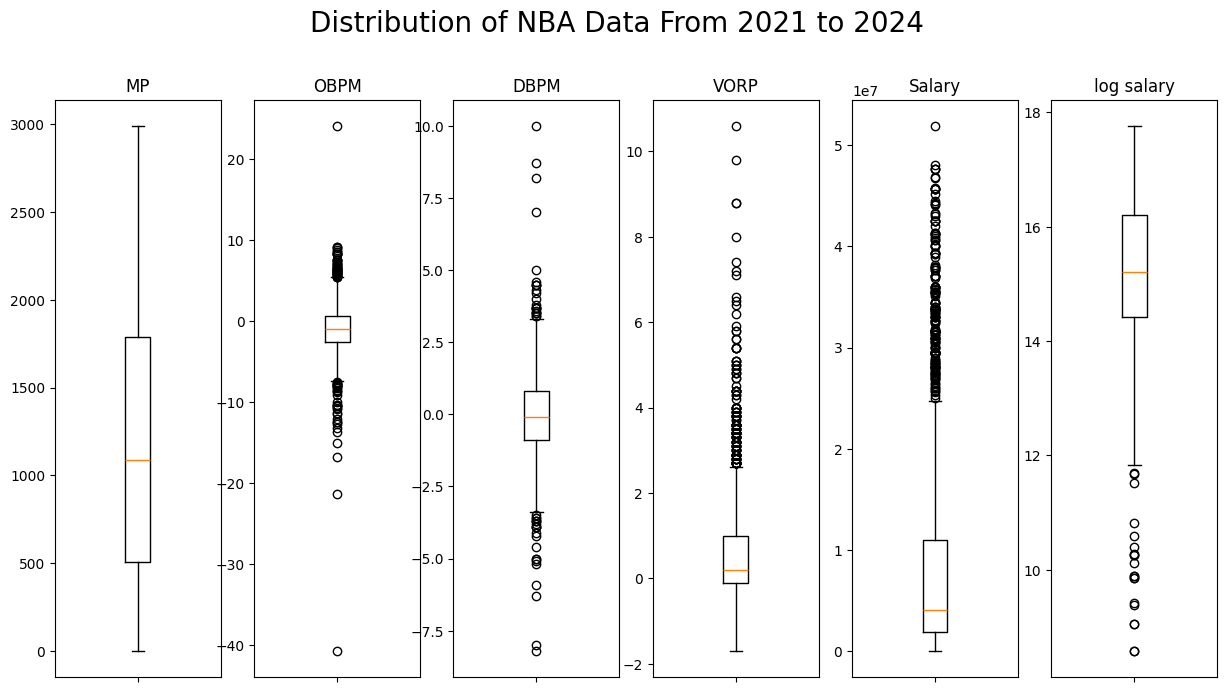

In [11]:
fig, ax = plt.subplots(1, 6, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary", "log salary"]

training_df = df_original[df_original["Year"].isin([2020,2021,2022,2023,2024])]

for j, col in enumerate(cols):
    ax[j].boxplot(training_df[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)

fig.suptitle("Distribution of NBA Data From 2021 to 2024", fontsize=20, y=1)
plt.show()


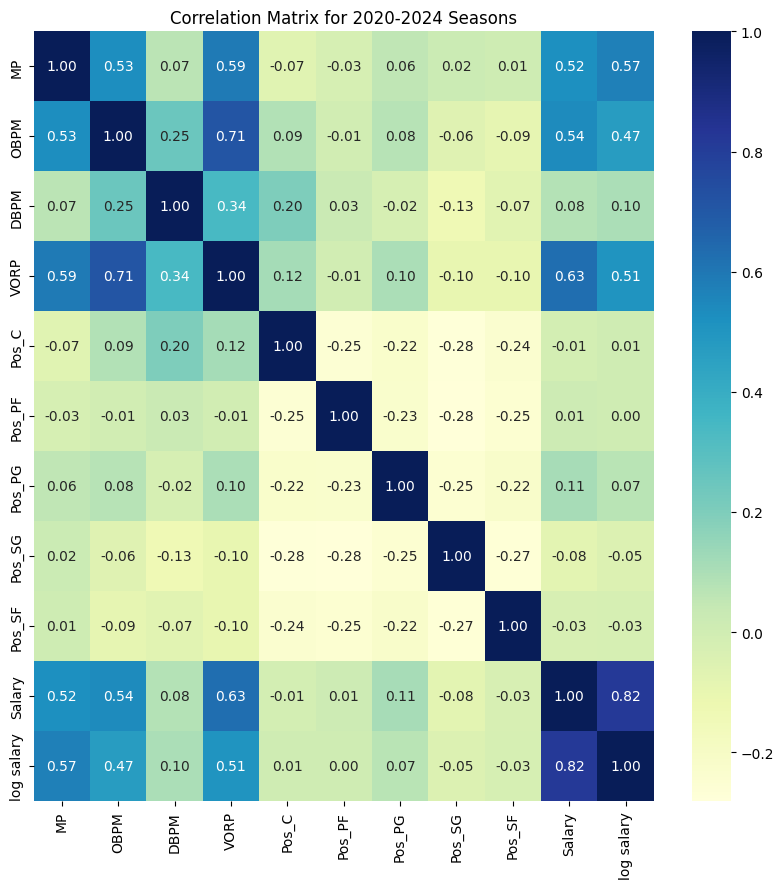

In [12]:
pos_encoded = pd.get_dummies(df_original['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_original, pos_encoded], axis=1)

df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "Salary", "log salary"]].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix for 2020-2024 Seasons")
plt.tick_params(axis="x", labelrotation=90)
plt.show() 

In [13]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
Salary        0.818862
MP            0.573303
VORP          0.507431
OBPM          0.471603
DBPM          0.101795
Pos_PG        0.068656
Pos_C         0.007949
Pos_PF        0.004706
Pos_SF       -0.025842
Pos_SG       -0.048783
Name: log salary, dtype: float64

In [14]:
from sklearn.preprocessing import StandardScaler

features = ["VORP", "OBPM", "MP", "Pos_PG", "DBPM", "Pos_PF", "Pos_C", "Pos_SF", "Pos_SG", ]

df = df.copy()

df_train = df[df["Year"] != 2025].copy()
df_test  = df[df["Year"] == 2025].copy()

X_train = df_train[features].copy()
y_train = df_train["log salary"].copy()

X_test = df_test[features].copy()
y_test = df_test["log salary"].copy()

# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
# X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()


In [15]:
from scipy.stats import uniform, randint

model = xgb.XGBRegressor(
    objective="reg:quantileerror",
    quantile_alpha=0.50,
    seed=42
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 0.990
R²: 0.325


In [16]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100, random_state=42)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 1.083
R²: 0.192


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
 
param_dist = {
    
    # Quartile regression parameters
    "objective": ["reg:quantileerror", "reg:squarederror"],
    "quantile_alpha": uniform(0.0, 1.0),
    
    # learning dynamics
    "learning_rate": uniform(0.02, 0.15),      # ~[0.02, 0.17]
    "n_estimators":  randint(500, 3000),        # integers

    # tree complexity
    "max_depth":     randint(3, 10),
    "min_child_weight": randint(1, 15),

    # variance control
    "subsample":     uniform(0.7, 0.3),         # [0.7, 1.0]
    "colsample_bytree": uniform(0.7, 0.3),
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=700,          # 700 * 4 = 2800 fits
    cv=4,
    n_jobs=-1,
    verbose=1,
    random_state=50,
)

search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_
best_params = search.best_params_
print("Best params:", best_params)
print("Best CV score:", search.best_score_)

Fitting 4 folds for each of 700 candidates, totalling 2800 fits
Best params: {'colsample_bytree': np.float64(0.9836851961516729), 'learning_rate': np.float64(0.023803469233412228), 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1743, 'objective': 'reg:quantileerror', 'quantile_alpha': np.float64(0.5033537548032887), 'subsample': np.float64(0.952662466386514)}
Best CV score: 0.3790499544786343


In [18]:
new_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    **best_params
)

new_model.fit(X_train_scaled, y_train)
y_pred = new_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


df_test["Predicted Log Salary"] = new_model.predict(df_test[features])
df_test["Residual"] = df_test["log salary"] - df_test["Predicted Log Salary"] 

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 0.954
R²: 0.372


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

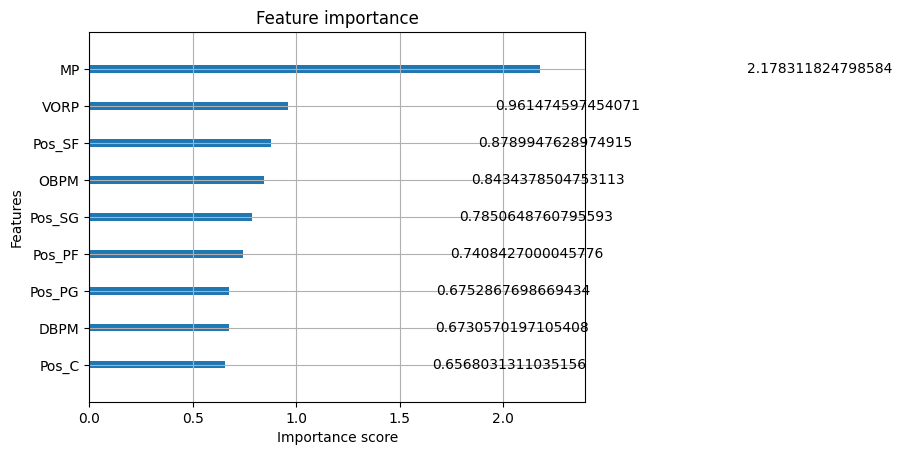

In [19]:
xgb.plot_importance(new_model, importance_type="gain")


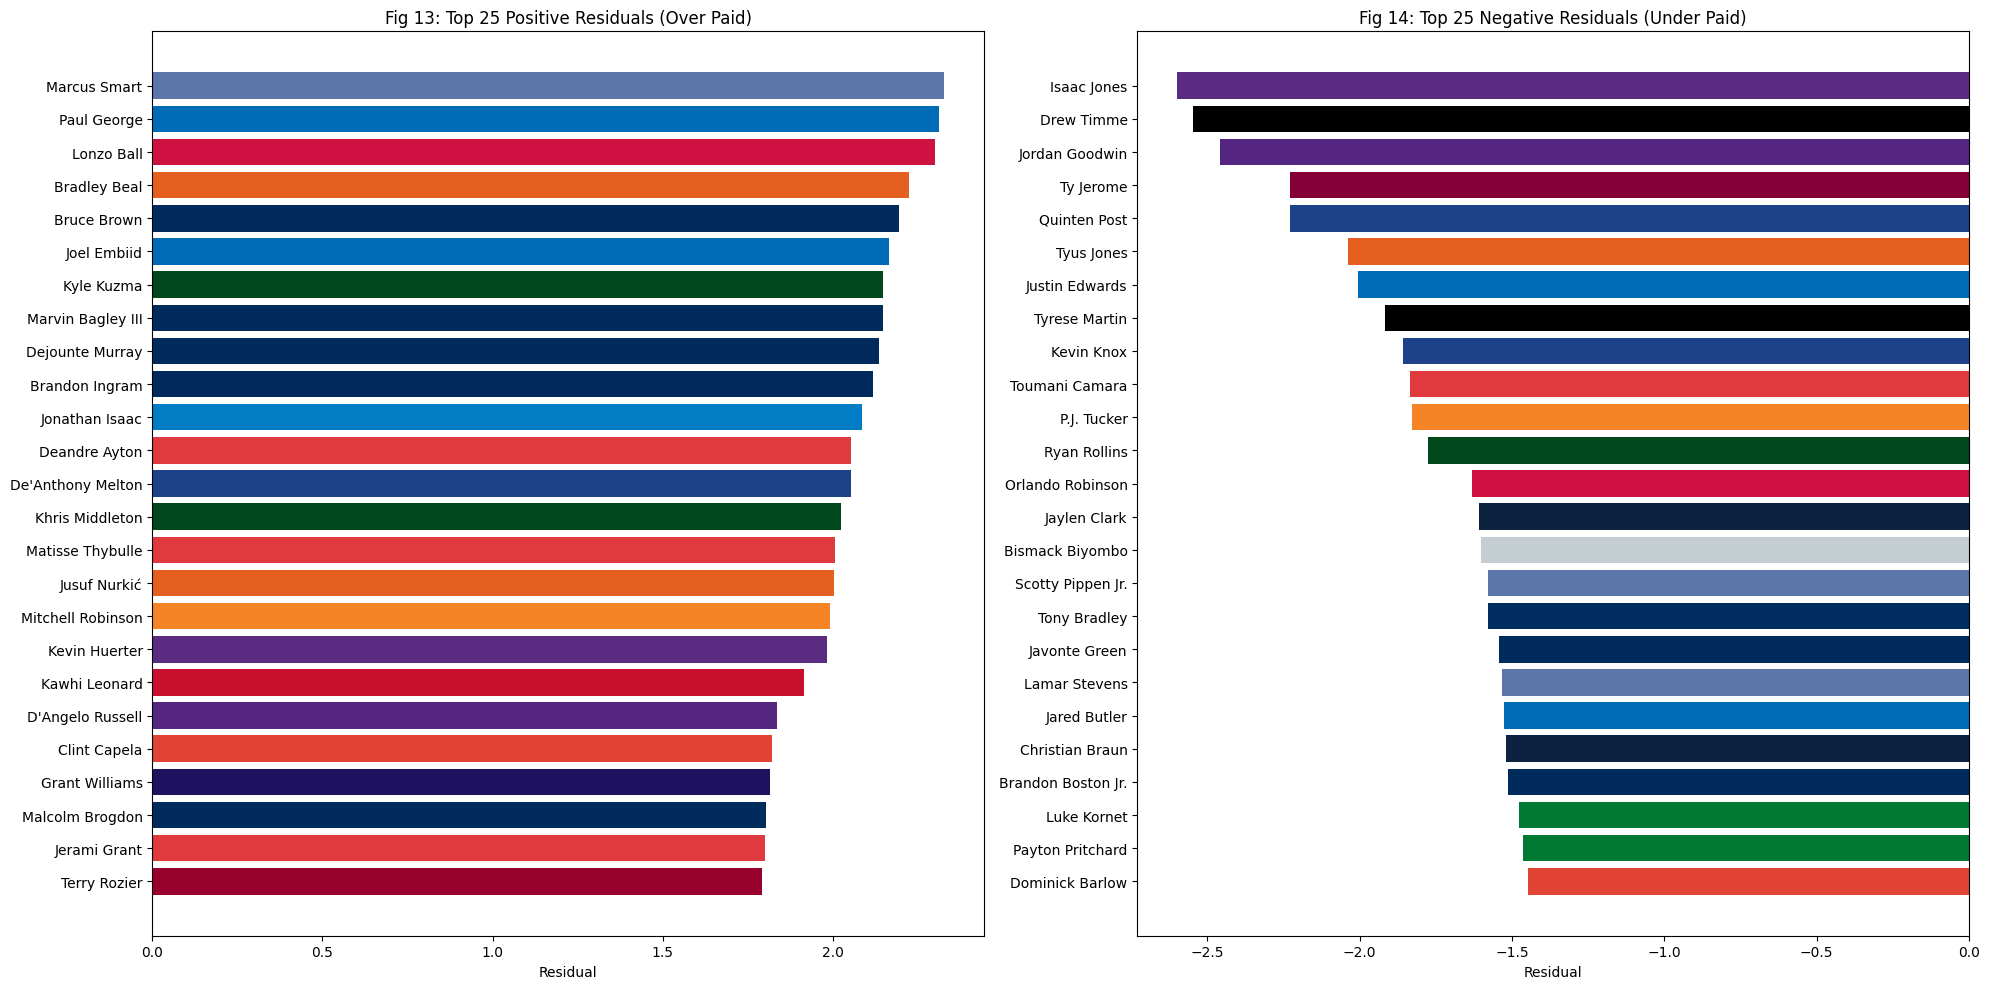

In [57]:


top_25 = df_test.sort_values("Residual", ascending=False).head(25).merge(color_df, on=["Team", ], how="left")
bottom_25 = df_test.sort_values("Residual", ascending=True).head(25).merge(color_df, on=["Team", ], how="left") 

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

# Overpaid (actual - predicted > 0)
ax[0].barh(top_25["Player"], top_25["Residual"], color=top_25["hex"])
ax[0].set_title("Fig 13: Top 25 Positive Residuals (Over Paid)")
ax[0].set_xlabel("Residual")
ax[0].invert_yaxis()

# Underpaid (actual - predicted < 0)
ax[1].barh(bottom_25["Player"], bottom_25["Residual"], color=bottom_25["hex"])
ax[1].set_title("Fig 14: Top 25 Negative Residuals (Under Paid)")
ax[1].set_xlabel("Residual")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

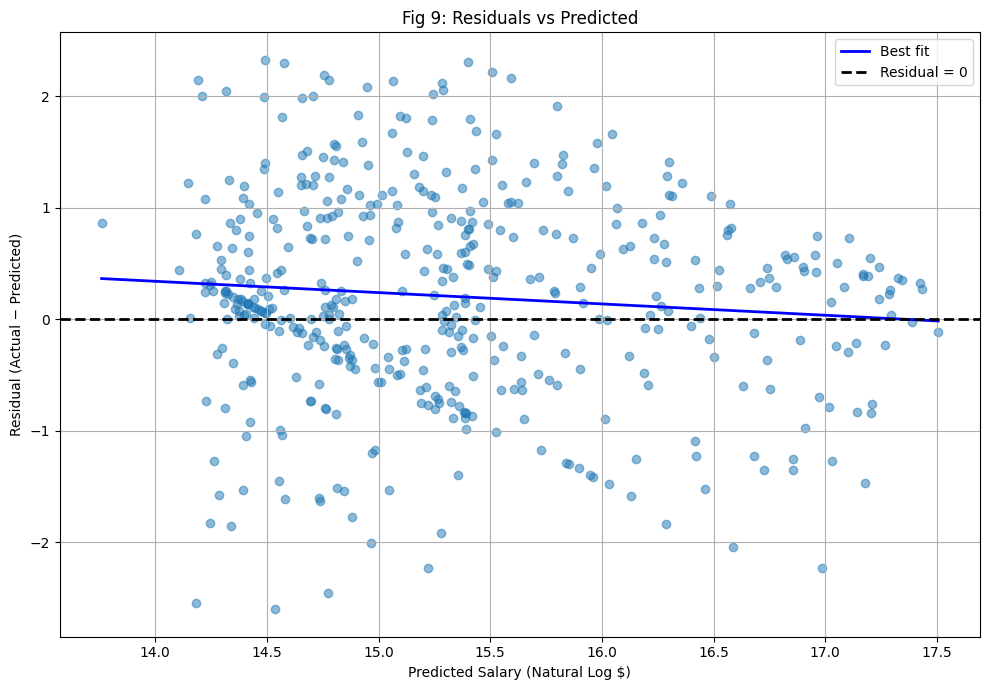

Corr Fig 1: -0.0931406722800131


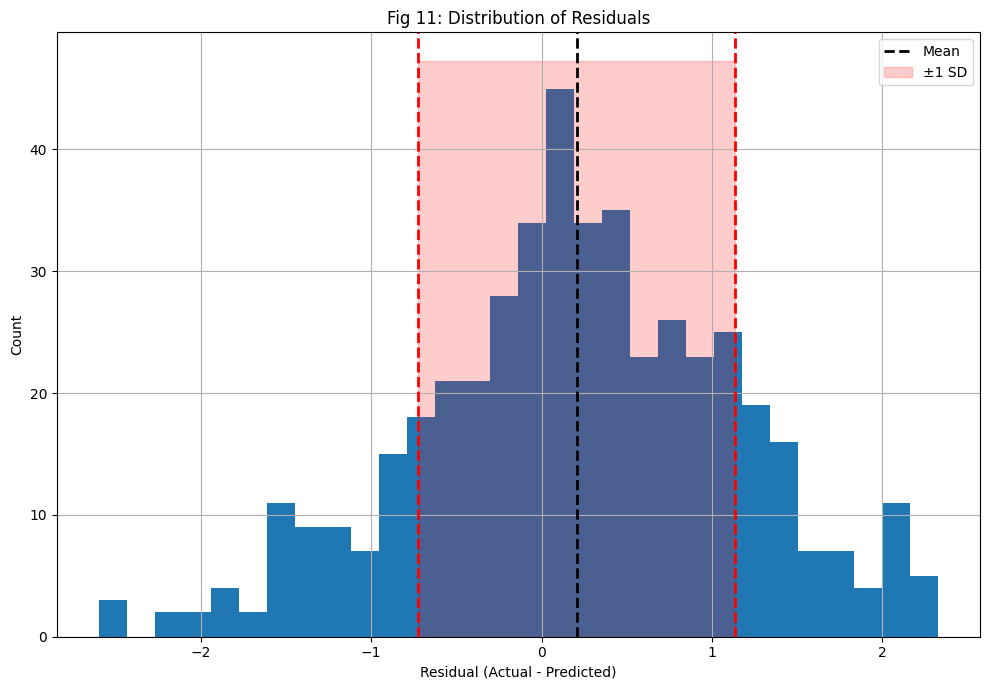

Corr Fig 3: 0.637583919366832


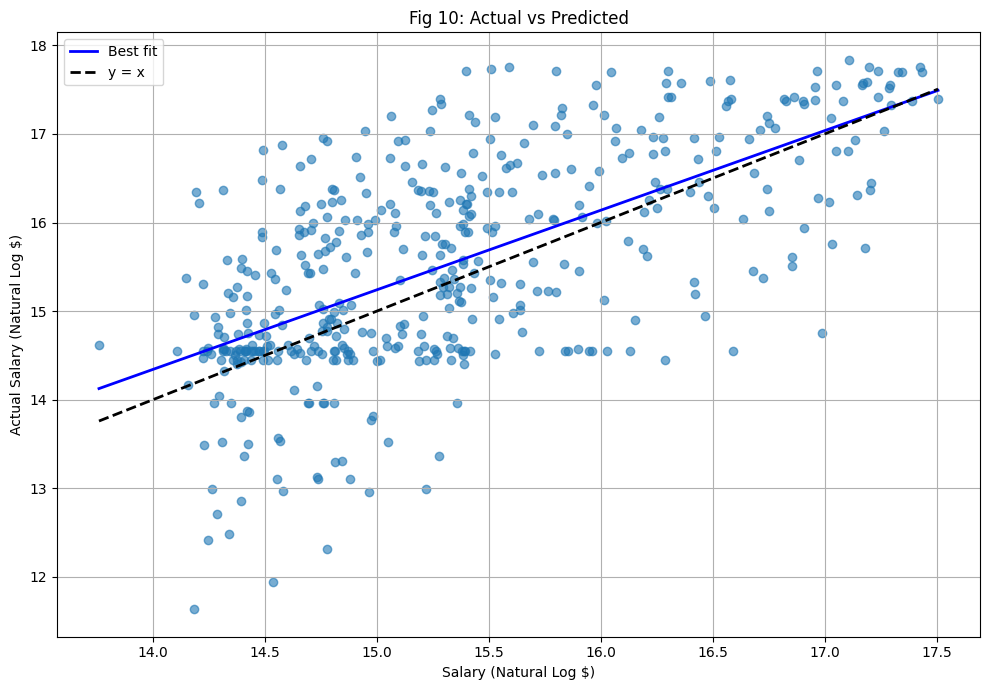

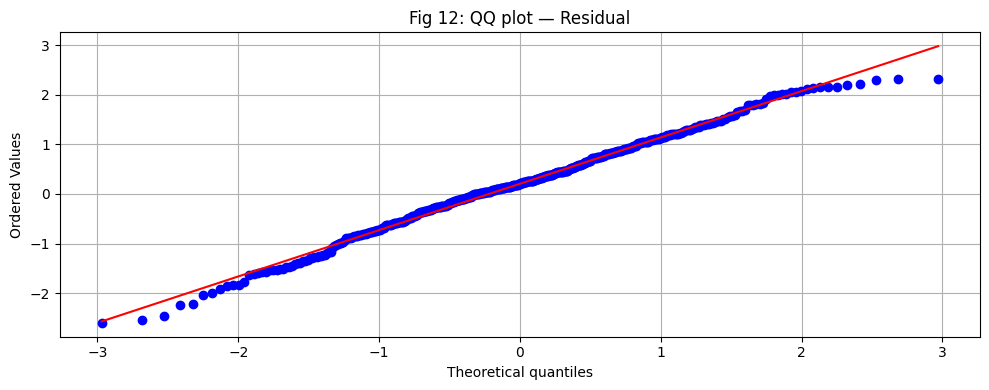

In [59]:
import numpy as np
import matplotlib.pyplot as plt

data = df_test.copy()

# =========================
# FIG 1: Residuals vs Predicted
# =========================
x = data["Predicted Log Salary"].to_numpy()
y = data["Residual"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y)

m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)

fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.scatter(x, y, alpha=0.5)
ax1.plot(xx, m*xx + b, linewidth=2, color="blue", label="Best fit")
ax1.axhline(0, linestyle="--", color="black", linewidth=2, label="Residual = 0")
ax1.set_xlabel("Predicted Salary (Natural Log $)")
ax1.set_ylabel("Residual (Actual − Predicted)")
ax1.set_title("Fig 9: Residuals vs Predicted")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()

print(f"Corr Fig 1: {np.corrcoef(x,y)[0][1]}")
# =========================
# FIG 2: Distribution of Residuals
# =========================
res = data["Residual"].to_numpy()
res = res[np.isfinite(res)]

mu = np.mean(res)
sd = np.std(res, ddof=1)

fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.hist(res, bins=30)
ax2.axvline(mu, linestyle="--", color="black", linewidth=2, label="Mean")
ax2.axvline(mu - sd, linestyle="--", color="red", linewidth=2)
ax2.axvline(mu + sd, linestyle="--", color="red", linewidth=2)

ymax = ax2.get_ylim()[1]
ax2.fill_between([mu - sd, mu + sd], 0, ymax, alpha=0.2, color="red", label="±1 SD")

ax2.set_ylabel("Count")
ax2.set_xlabel("Residual (Actual - Predicted)")
ax2.set_title("Fig 11: Distribution of Residuals")
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()


# =========================
# FIG 3: Actual vs Predicted
# =========================
x = data["Predicted Log Salary"].to_numpy()   # predicted
y = data["log salary"].to_numpy()             # actual

mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]
print(f"Corr Fig 3: {np.corrcoef(x,y)[0][1]}")

m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)

fig3, ax3 = plt.subplots(figsize=(10, 7))
ax3.scatter(x, y, alpha=0.6)
ax3.plot(xx, m*xx + b, linewidth=2, color="blue", label="Best fit")
ax3.plot(xx, xx, linestyle="--", linewidth=2, color="black", label="y = x")

ax3.set_xlabel("Salary (Natural Log $)")
ax3.set_ylabel("Actual Salary (Natural Log $)")
ax3.set_title("Fig 10: Actual vs Predicted")
ax3.grid(True)
ax3.legend()
plt.tight_layout()
plt.show()


import scipy.stats as stats


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
x = data["Residual"].to_numpy()
stats.probplot(x, dist="norm", plot=ax)
ax.set_title("Fig 12: QQ plot — Residual")
ax.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

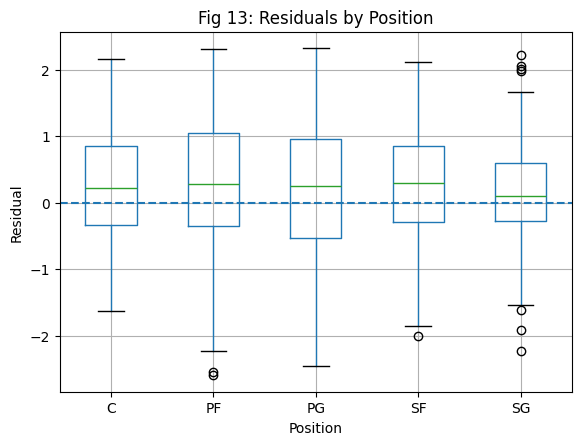

In [22]:
plt.figure(figsize=(10,6))
df_test.boxplot(column="Residual", by="Pos")
plt.axhline(0, linestyle="--")
plt.title("Fig 13: Residuals by Position")
plt.suptitle("")
plt.xlabel("Position")
plt.ylabel("Residual")
plt.show()

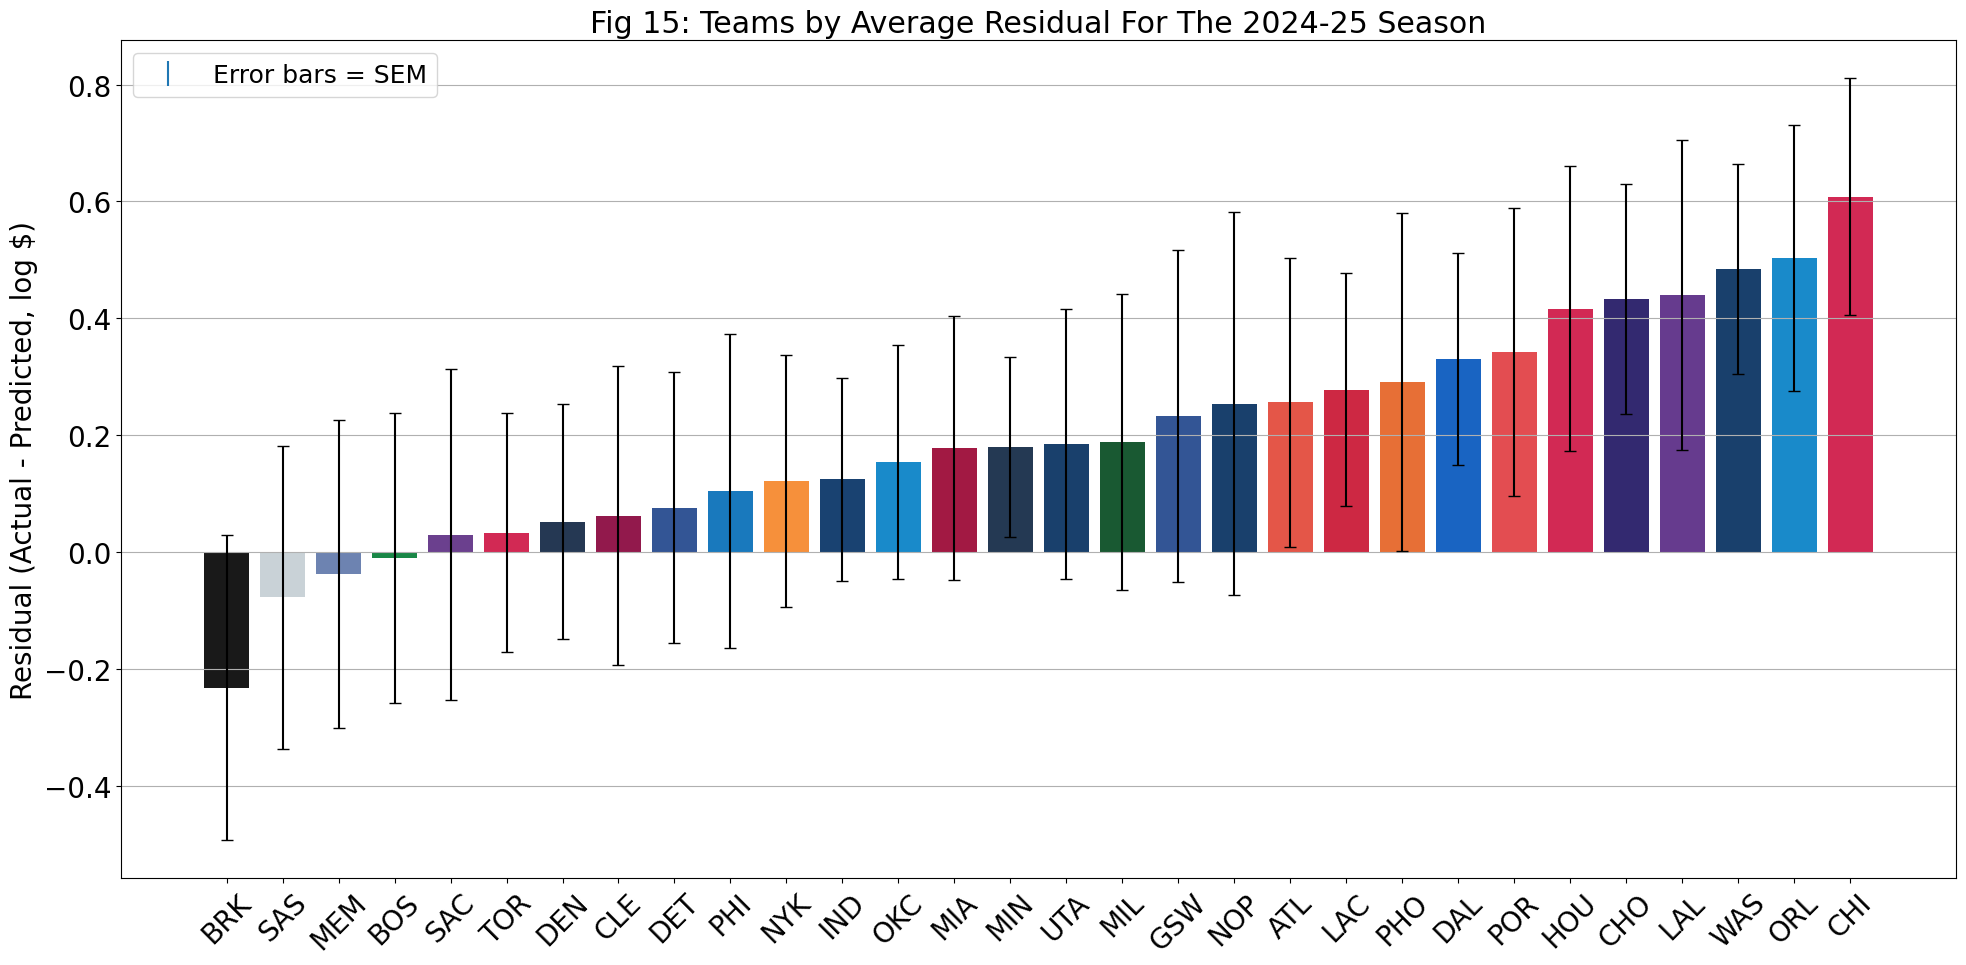

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
team_stats = (
    df_test.groupby("Team")["Residual"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
team_stats["sem"] = team_stats["std"] / np.sqrt(team_stats["n"])

data = (
    team_stats.sort_values("mean", ascending=True).merge(color_df, on="Team", how="left")
)

ax.bar(
    x=data["Team"],
    height=data["mean"],
    color=data["hex"],
    yerr=data["sem"],   # or: data["std"]
    capsize=4,
    
    alpha=0.9
)

ax.set_title("Fig 15: Teams by Average Residual For The 2024-25 Season")
ax.set_ylabel("Residual (Actual - Predicted, log $)")
ax.grid(True, axis="y")
ax.tick_params(axis="x", rotation=45)
ax.errorbar([], [], yerr=[1], fmt="none", capsize=10, label="Error bars = SEM")
ax.legend()
plt.tight_layout()
plt.show()

In [43]:
data = df_test.copy()
data[data["Team"] == "SAS"].sort_values(by="Residual")


,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Predicted Log Salary,Residual
204,Bismack Biyombo,biyombi01,SAS,528,-3.6,0.0,-0.2,C,2025,503884.0,13.130101,1,0,0,0,0,14.732550,-1.602448
1300,Sandro Mamukelashvili,mamuksa01,SAS,681,3.3,-1.0,0.7,PF,2025,2087519.0,14.551487,0,1,0,0,0,15.960615,-1.409128
2197,Victor Wembanyama,wembavi01,SAS,1527,3.6,2.9,3.3,C,2025,12768960.0,16.362528,1,0,0,0,0,17.203714,-0.841187
392,Julian Champagnie,champju02,SAS,1932,-0.3,-0.9,0.4,SF,2025,3000000.0,14.914123,0,0,0,1,0,15.546873,-0.632750
1650,Chris Paul,paulch01,SAS,2292,0.3,0.5,1.6,PG,2025,10460000.0,16.163069,0,0,1,0,0,16.504042,-0.340973
130,Harrison Barnes,barneha02,SAS,2230,1.7,-1.7,1.2,PF,2025,18000000.0,16.705882,0,1,0,0,0,16.886930,-0.181048
2200,Blake Wesley,weslebl01,SAS,683,-3.9,-0.3,-0.4,SG,2025,2624280.0,14.780317,0,0,0,0,1,14.753377,0.026940
146,Charles Bassey,bassech01,SAS,376,-1.7,0.6,0.1,C,2025,2087519.0,14.551487,1,0,0,0,0,14.475242,0.076245
1960,Jeremy Sochan,sochaje01,SAS,1364,-0.8,-0.4,0.3,PF,2025,5570040.0,15.532913,0,1,0,0,0,15.385474,0.147439
386,Stephon Castle,castlst01,SAS,2162,-1.5,-1.7,-0.6,SG,2025,9131760.0,16.027269,0,0,0,0,1,15.790582,0.236687
